# Jellium
[?](?)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

# from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA
from hnc.hnc.PIE_TwoElectron import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas, Degeneracy_Parameter, Fermi_Energy

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


### Set Parameters in Paper and Plot

In [5]:
name = 'Jellium'
Z, A = 1,1 

Te_eV = 0.001 # eV
rs_AU = 1
rs_cm = rs_AU/cm_to_AU
ne_cc = n_from_rs(rs_cm)
ne_AU = n_from_rs(rs_AU)


#### Run Ornstein-Zernike Closure

In [6]:
# Helpful unit functions
P_hnc_to_AU   = lambda P_hnc, ri: (P_hnc/ri**3) 
P_hnc_to_bar  = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc, ri: 1e-6*P_hnc_to_bar(P_hnc, ri)
P_hnc_to_GPa  = lambda P_hnc, ri: P_hnc_to_bar(P_hnc, ri) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc, ri: E_hnc/(3/(4*π)) * AU_to_eV

P_hnc_to_AU = np.vectorize(P_hnc_to_AU)
P_hnc_to_bar = np.vectorize(P_hnc_to_bar)
P_hnc_to_Mbar = np.vectorize(P_hnc_to_Mbar)
P_hnc_to_GPa = np.vectorize(P_hnc_to_GPa)
E_hnc_to_eV = np.vectorize(E_hnc_to_eV)

def get_jellium_P_Mbar(jellium_hnc):
    # jellium_hnc.h_r_matrix -= 1
    P_hnc = jellium_hnc.excess_pressure_matrix()
    # jellium_hnc.h_r_matrix += 1
    return P_hnc_to_Mbar(P_hnc)[0,0]


In [7]:
jellium_func = lambda Te_eV, ne_cc: PLASMA(1, 1, ne_cc, Te_eV, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Make Jellium PLASMA object
jellium = jellium_func(Te_eV, ne_cc)
jellium.run_jellium_hnc(ideal=True)



Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 1.411e-01


/home/zach/plasma/hnc/hnc/PIE_TwoElectron.py:177: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


Exiting status 0, reverting to best index so far: 39
Final iter:40, Total Error: 8.814e-09


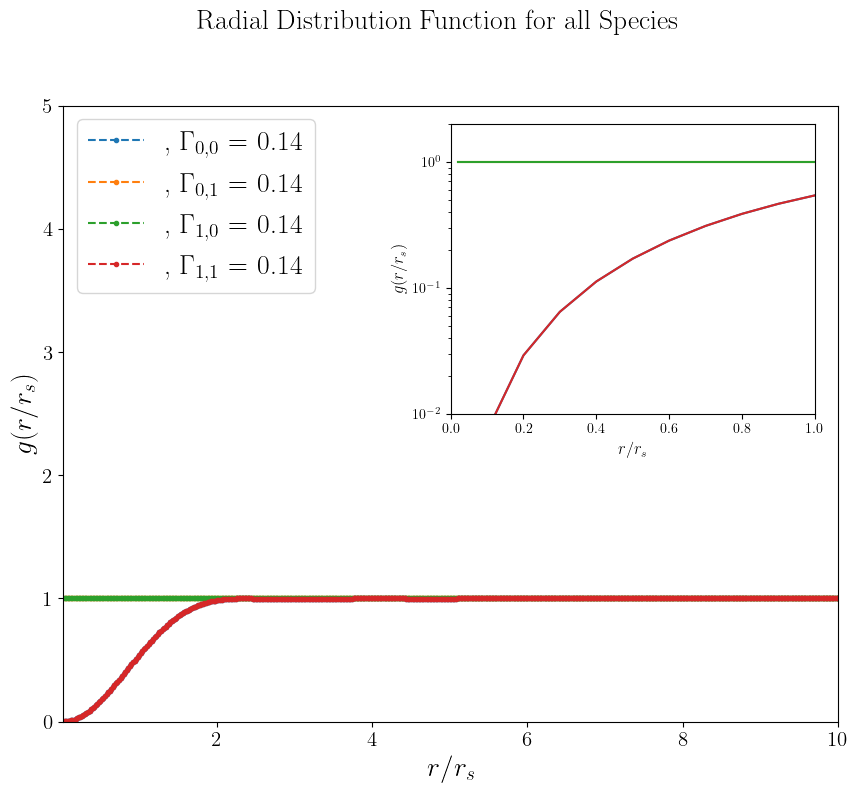

In [8]:
jellium.jellium_hnc.plot_g_all_species()

#### DW & Perrot Formula for Exc


In [9]:
from scipy.integrate import simpson, quad
 
def Exc_λ(jellium, which='standard'):
    if which=='standard':
        return Exc_λ_standard(jellium)
    elif which=='qsp':
        return Exc_λ_standard(jellium) + δExc_λ_qsp(jellium)
    
def Exc_λ_standard(jellium): 
    r = jellium.jellium_hnc.r_array*jellium.qsp.re

    h_uu = jellium.jellium_hnc.h_r_matrix[0,0]
    h_ud = jellium.jellium_hnc.h_r_matrix[0,1]
    
    integrand = 4*π*r**2 / r * (h_uu + h_ud)
    
    Exc_lambda = ne_AU/4  * simpson(integrand,x=r)
    return Exc_lambda
    
def δExc_λ_qsp(jellium): 
    r_array = jellium.jellium_hnc.r_array
    r = r_array*jellium.qsp.re

    g_uu = jellium.jellium_hnc.h_r_matrix[0,0] + 1
    g_ud = jellium.jellium_hnc.h_r_matrix[0,1] + 1
    
    δu_uu =  jellium.qsp.Te_c*(jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array) - jellium.qsp.Γee/r_array) 
    δu_ud =  jellium.qsp.Te_c*(jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array) - jellium.qsp.Γee/r_array) 
    
    integrand = 4*π*r**2 *(  δu_uu * g_uu + δu_ud * g_ud )
    
    δExc_lambda = ne_AU/4  * simpson(integrand,x=r)
    return δExc_lambda
    
def get_integral_for_λ(λ, **kwargs):
    jellium = jellium_func(Te_eV, ne_cc)
    print(f"θ = {Degeneracy_Parameter(Te_eV*eV_to_AU, ne_cc/cm_to_AU**3)}")
    jellium.make_jellium_hnc(ideal=False)
 
    r_array = jellium.hnc.r_array
    
    βv_uu_P = jellium.βP_uu #jellium.qsp.βv_Pauli(r_array)
    βv_ud_P = np.zeros_like(jellium.βP_uu) #jellium.qsp.βv_Pauli(r_array)
    βv_uu = βv_uu_P + λ * (jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array))
    βv_ud = βv_ud_P + λ * (jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array))
    
    jellium.jellium_hnc.set_βu_matrix(np.array([[  βv_uu, βv_ud  ],
                                                [  βv_ud, βv_uu  ]]))

    jellium.jellium_hnc.HNC_solve(**jellium.hnc_solve_options)
        
    return Exc_λ(jellium, **kwargs)

def get_Exc(**kwargs):
    Exc_λ = lambda λ: get_integral_for_λ(λ, **kwargs)
    
    λ_array = np.linspace(0,1,num=10)
    Exc_λ = np.vectorize(Exc_λ)
    Exc_λ_array = Exc_λ(λ_array)
    return λ_array, Exc_λ_array



In [10]:
std_output = get_Exc(which='standard')
qsp_output = get_Exc(which='qsp')

Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
θ = 1.9956295498082892e-05
0: Initial condition Total Error: 1.411e-01


/home/zach/plasma/hnc/hnc/PIE_TwoElectron.py:177: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


Exiting status 0, reverting to best index so far: 39
Final iter:40, Total Error: 8.814e-09
Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
θ = 1.9956295498082892e-05
0: Initial condition Total Error: 1.411e-01
Exiting status 0, reverting to best index so far: 39
Final iter:40, Total Error: 8.814e-09
Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
θ = 1.9956295498082892e-05
0: Initial condition Total Error: 1.429e-01
Exiting status 0, reverting to best index so far: 39
Final iter:40, Total Error: 9.468e-09
Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
θ = 1.9956295498082892e-05
0: Initial condition Total Error: 1.447e-01
Exiting status 0, reverting to best index so far: 40
Final iter:41, Total Error: 6.761e-09
Te_in_eV: 0.001
Ti_in_eV: 0.001
Warning, small T

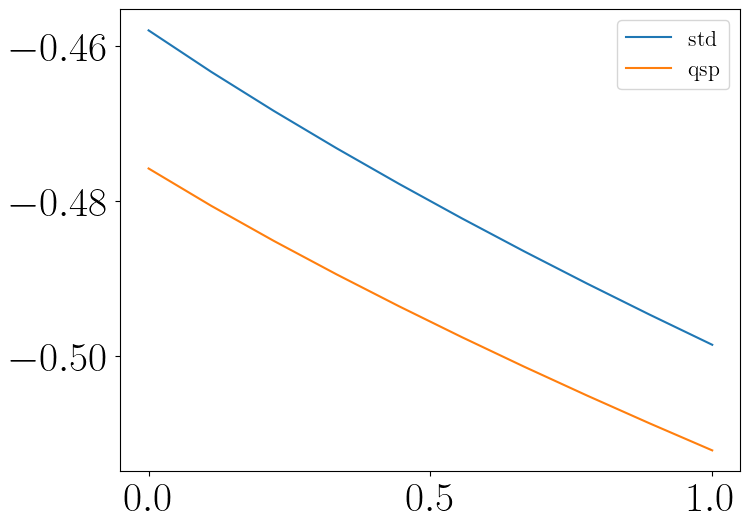

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(std_output[0], std_output[1], label='std')
ax.plot(qsp_output[0], qsp_output[1], label='qsp')
ax.legend(fontsize=16)

In [12]:
E_xc_std = simpson(std_output[1], std_output[0])
E_xc_qsp = simpson(qsp_output[1], qsp_output[0])

In [13]:
print(f"Te_c/EF = {jellium.qsp.Te_c/jellium.qsp.E_F:0.3f}")
print(f"Standard results: rs={rs_AU:0.3f}, E_xc/Ne = {E_xc_std:0.4f} [AU], Ex/Ne = {Exc_λ(jellium):0.4f} AU ")
print(f"QSP results: rs={rs_AU:0.3f}, E_xc/Ne = {E_xc_qsp:0.4f} [AU], Ex/Ne = {Exc_λ(jellium, which='qsp'):0.4f} AU ")

Te_c/EF = 4.000
Standard results: rs=1.000, E_xc/Ne = -0.4795 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = -0.4950 [AU], Ex/Ne = -0.4758 AU 


#### Notes

Te_c/EF = 4.000
Standard results: rs=1.000, E_xc/Ne = -0.4795 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = -0.4950 [AU], Ex/Ne = -0.4758 A

Te_c/EF = 2.000
Standard results: rs=1.000, E_xc/Ne = -0.4935 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = -0.5257 [AU], Ex/Ne = -0.4954 AU 

Te_c/EF = 1.000
Standard results: rs=1.000, E_xc/Ne = -0.5120 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = -0.5816 [AU], Ex/Ne = -0.5388 AU 

Te_c/EF = 0.872
Standard results: rs=1.000, E_xc/Ne = -0.5160 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = ? [AU], Ex/Ne = -0.5524 AU 

Te_c/EF = 0.200
Standard results: rs=1.000, E_xc/Ne = -0.5503 [AU], Ex/Ne = -0.4580 AU 
QSP results: rs=1.000, E_xc/Ne = -1.0292 [AU], Ex/Ne = -0.9779 AU 

In [19]:
-0.458/rs_AU, -0.44/(rs_AU + 7.8), -0.458/rs_AU + -0.44/(rs_AU + 7.8)

(-0.458, -0.049999999999999996, -0.508)